In [44]:
# "The social benefits of emotion variability"
# Analysis script for Study 6 
# Evan W. Carr, 05-20-2018 (Columbia Business School)

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf

from plotnine import *
from rpy2.robjects import r, pandas2ri

%matplotlib inline

# Set working directory to location of data files, and read in .csv's:
rawData = pd.read_csv("manic9_exptrun_final_clean_18_05_20.csv")
rawDemog = pd.read_csv("demographics_survey_survey_18_05_20.csv")

rawData.head(20)

,date,time,group,subject,build,blocknum,trialnum,blockcode,trialcode,pretrialpause,...,latency,stimulusnumber1,stimulusitem1,stimulusonset1,stimulusnumber2,stimulusitem2,stimulusonset2,stimulusnumber3,stimulusitem3,stimulusonset3
0,51518,16:44:43,708027252,24404513,5.0.11.0,1,1,expt_intro,expt_intro,0,...,6227,1,"Welcome to the study! During this session, ...",1,1,cbs_logo.jpg,1,1,"If you need to exit the study early, you can d...",1
1,51518,16:44:43,708027252,24404513,5.0.11.0,2,1,hv3_male_block,hv3_male_trial,0,...,500,63,M07_happy50.jpg,0,0,0,0,0,0,0
2,51518,16:44:43,708027252,24404513,5.0.11.0,2,2,hv3_male_block,hv3_male_trial,0,...,500,88,M07_sad50.jpg,0,0,0,0,0,0,0
3,51518,16:44:43,708027252,24404513,5.0.11.0,2,3,hv3_male_block,hv3_male_trial,0,...,500,68,M07_happy50.jpg,0,0,0,0,0,0,0
4,51518,16:44:43,708027252,24404513,5.0.11.0,2,4,hv3_male_block,hv3_male_trial,0,...,500,80,M07_angry50.jpg,0,0,0,0,0,0,0
5,51518,16:44:43,708027252,24404513,5.0.11.0,2,5,hv3_male_block,hv3_male_trial,0,...,500,62,M07_happy50.jpg,0,0,0,0,0,0,0
6,51518,16:44:43,708027252,24404513,5.0.11.0,2,6,hv3_male_block,hv3_male_trial,0,...,500,67,M07_happy50.jpg,0,0,0,0,0,0,0
7,51518,16:44:43,708027252,24404513,5.0.11.0,2,7,hv3_male_block,hv3_male_trial,0,...,500,64,M07_happy50.jpg,0,0,0,0,0,0,0
8,51518,16:44:43,708027252,24404513,5.0.11.0,2,8,hv3_male_block,hv3_male_trial,0,...,500,65,M07_happy50.jpg,0,0,0,0,0,0,0
9,51518,16:44:43,708027252,24404513,5.0.11.0,2,9,hv3_male_block,hv3_male_trial,0,...,500,90,M07_sad50.jpg,0,0,0,0,0,0,0


In [45]:
# All subjects should have 386 observations (rows) in the dataset ...
# Any that don't have 386 did not finish the study, and need to be removed before analysis:
rawObsCount = rawData.groupby('subject', as_index=False).size().reset_index(name='counts')
rawObsCount.sort_values(by='counts').head(30)

,subject,counts
81,413337119,32
49,227047725,34
4,24404513,34
153,883000816,64
156,918259732,96
71,356009397,96
29,156961589,96
64,317768747,241
148,872914894,256
145,865265487,294


In [46]:
# Create list of subject ID's to exclude (subjects that don't have 386 observations):
exclSbj = rawObsCount.query('counts != 386')
exclSbj = np.array(exclSbj['subject'])
exclSbj

array([ 24404513, 156961589, 162238232, 174474106, 227047725, 317768747,
       356009397, 413337119, 646194416, 836092869, 865265487, 869692151,
       872914894, 883000816, 918259732], dtype=int64)

In [47]:
# Filter to important columns, and exclude subjects that didn't finish the study:
cleanCols = ['subject', 'blocknum', 'trialnum', 'blockcode', 'trialcode', 'response', 'latency', 'stimulusitem1']
cleanData = rawData.loc[~rawData['subject'].isin(exclSbj)][cleanCols]
cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1
309,580558972,1,1,expt_intro,expt_intro,57.0,21199,"Welcome to the study! During this session, ..."
310,580558972,2,1,lv1_female_block,lv1_female_trial,0.0,500,F03_angry50.jpg
311,580558972,2,2,lv1_female_block,lv1_female_trial,0.0,500,F03_angry50.jpg
312,580558972,2,3,lv1_female_block,lv1_female_trial,0.0,500,F03_angry50.jpg
313,580558972,2,4,lv1_female_block,lv1_female_trial,0.0,500,F03_happy50.jpg


In [48]:
# Quickly check subject times to complete the study (should usually be between 5-10 minutes):
completionTimes = cleanData.groupby('subject').agg({'latency': 'sum'}).reset_index()
completionTimes['latency_mins'] = (completionTimes['latency'] / 1000) / 60
completionTimes.head(10)

,subject,latency,latency_mins
0,7485509,299473,4.991217
1,11569630,359583,5.993050
2,12041251,330424,5.507067
3,24236825,393576,6.559600
4,24941821,296866,4.947767
5,32414682,329190,5.486500
6,41465525,331653,5.527550
7,52523433,284140,4.735667
8,65997624,294314,4.905233
9,66916785,571804,9.530067


In [49]:
# Get quick demographics summary, without excluded subjects:
demogSummary = rawDemog.groupby('subject').agg({'age_response': np.mean, "gender_response": pd.Series.unique}).reset_index()
demogSummary = demogSummary[~demogSummary['subject'].isin(exclSbj)]

demogSummary['age_response'].mean()

37.16

In [50]:
demogSummary['age_response'].std()

12.35443023003185

In [51]:
demogSummary['gender_response'].value_counts()

Female    82
Male      68
Name: gender_response, dtype: int64

In [52]:
# Create column for emotion variability condition ('model_block'):
cleanData = cleanData.join(cleanData['blockcode'].str.split('_', 1, expand=True).rename(columns={0:'model_block', 1:'junk'}))
cleanData = cleanData.drop(['junk'], axis=1)
cleanData.head()
cleanData['model_block'].unique()

array(['expt', 'lv1', 'hv2', 'hv1', 'lv3', 'hv3', 'lv2'], dtype=object)

In [53]:
# Map emotion variability condition ('model_block') to umbrella factor: 
varDict = {'expt': 'expt',
           'lv1': 'lv',
           'lv2': 'lv',
           'lv3': 'lv',
           'hv1': 'hv',
           'hv2': 'hv',
           'hv3': 'hv'}

cleanData['model_block_variability'] = cleanData['model_block'].map(varDict)

cleanData.head()

,subject,blocknum,trialnum,blockcode,trialcode,response,latency,stimulusitem1,model_block,model_block_variability
309,580558972,1,1,expt_intro,expt_intro,57.0,21199,"Welcome to the study! During this session, ...",expt,expt
310,580558972,2,1,lv1_female_block,lv1_female_trial,0.0,500,F03_angry50.jpg,lv1,lv
311,580558972,2,2,lv1_female_block,lv1_female_trial,0.0,500,F03_angry50.jpg,lv1,lv
312,580558972,2,3,lv1_female_block,lv1_female_trial,0.0,500,F03_angry50.jpg,lv1,lv
313,580558972,2,4,lv1_female_block,lv1_female_trial,0.0,500,F03_happy50.jpg,lv1,lv


In [54]:
# Access and log stimulus model ID codes for inclusion in mixed-effects models (shown later):
ratingsList = ['authenticity_slider', 'negativity_slider']
modelSummary = cleanData.groupby(['subject', 'blocknum']).agg({"stimulusitem1": pd.Series.unique}).reset_index()

modelSummary.head(10)

,subject,blocknum,stimulusitem1
0,7485509,1,"Welcome to the study! During this session, ..."
1,7485509,2,"[M04_happy50.jpg, M04_angry50.jpg, cbs_logo.jpg]"
2,7485509,3,"[F04_angry50.jpg, F04_happy50.jpg, cbs_logo.jpg]"
3,7485509,4,"[F06_sad50.jpg, F06_fear50.jpg, F06_happy50.jp..."
4,7485509,5,"[F01_happy50.jpg, F01_angry50.jpg, cbs_logo.jpg]"
5,7485509,6,"[M11_happy50.jpg, M11_sad50.jpg, M11_angry50.j..."
6,7485509,7,"[M03_happy50.jpg, M03_angry50.jpg, M03_fear50...."
7,7485509,8,"[M09_happy50.jpg, M09_angry50.jpg, cbs_logo.jpg]"
8,7485509,9,"[M07_angry50.jpg, M07_happy50.jpg, cbs_logo.jpg]"
9,7485509,10,"[M12_fear50.jpg, M12_happy50.jpg, M12_sad50.jp..."


In [55]:
# 'modelSummary' dataframe shows all unique stimuli shown to each subject, by blocknum ...
# Not useful yet, but will be if we can split stimulus names apart:
modelList = []
for i in range(0, modelSummary.shape[0]):
    modelID = modelSummary.iloc[i]['stimulusitem1'][0].split('_', 1)[0]
    modelList.append(modelID)
    
modelSummary['model_id'] = modelList
modelSummary = modelSummary.drop('stimulusitem1', axis=1)

modelSummary.head(15)

,subject,blocknum,model_id
0,7485509,1,W
1,7485509,2,M04
2,7485509,3,F04
3,7485509,4,F06
4,7485509,5,F01
5,7485509,6,M11
6,7485509,7,M03
7,7485509,8,M09
8,7485509,9,M07
9,7485509,10,M12


In [56]:
# Subjects only saw real stimuli in blocknum's 2-13 ...
# Do an inner join with the main data to get only those blocks, then filter to only when subjects gave ratings:
cleanRatings = pd.merge(cleanData, modelSummary, on=('subject', 'blocknum'), how='inner')
cleanRatings = cleanRatings.loc[(cleanRatings['model_block'] != 'expt') & (cleanRatings['trialcode'].isin(ratingsList)), :]
cleanRatings = cleanRatings.drop(['blocknum', 'trialnum', 'blockcode', 'stimulusitem1'], axis=1)

cleanRatings.head(40)

,subject,trialcode,response,latency,model_block,model_block_variability,model_id
31,580558972,negativity_slider,67.0,7012,lv1,lv,F03
32,580558972,authenticity_slider,78.0,5767,lv1,lv,F03
63,580558972,authenticity_slider,72.0,6630,hv2,hv,F01
64,580558972,negativity_slider,72.0,4015,hv2,hv,F01
95,580558972,authenticity_slider,67.0,3961,hv1,hv,M11
96,580558972,negativity_slider,39.0,3514,hv1,hv,M11
127,580558972,authenticity_slider,30.0,6783,lv3,lv,M12
128,580558972,negativity_slider,72.0,3494,lv3,lv,M12
159,580558972,authenticity_slider,74.0,3080,lv3,lv,F02
160,580558972,negativity_slider,40.0,4626,lv3,lv,F02


In [57]:
# Create individual datasets for each major DV:
authenticityData = cleanRatings.query("trialcode == 'authenticity_slider'")
negativityData = cleanRatings.query("trialcode == 'negativity_slider'")

In [58]:
# Run mixed-effects models on each DV:
#    - fixed = variability (high vs. low)
#    - random = subject_id & model_id

# Push objects to R to start analyses ...
# (statsmodels package in python has trouble fitting certain random-effect structures):

pandas2ri.activate()
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [59]:
# Send datasets with ratings to R: 
%R -i authenticityData,negativityData

In [60]:
%%R

# Use R to create mixed-effects models with both subject- and stimulus-level random effects:

library(lmerTest)

a_m1 <- lmer(response ~ model_block_variability + (1|subject) + (1|model_id), data=authenticityData)
a_m1_anova <- anova(a_m1)
a_m1_lsmeans <- lsmeans(a_m1)
a_m1_difflsmeans <- difflsmeans(a_m1)
             
n_m1 <- lmer(response ~ model_block_variability + (1|subject) + (1|model_id), data=negativityData)
n_m1_anova <- anova(n_m1)
n_m1_lsmeans <- lsmeans(n_m1)
n_m1_difflsmeans <- difflsmeans(n_m1)

In [61]:
# Pull model results back to python:
%R -o a_m1_anova,a_m1_lsmeans,a_m1_difflsmeans,n_m1_anova,n_m1_lsmeans,n_m1_difflsmeans

In [62]:
# Variability significantly affects authenticity ratings:
pandas2ri.ri2py(a_m1_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_variability,6831.735598,6831.735598,1,1643.454475,15.57096,0.000083


In [63]:
# Variability significantly affects negativity ratings:
pandas2ri.ri2py(n_m1_anova)

,Sum Sq,Mean Sq,NumDF,DenDF,F.value,Pr(>F)
model_block_variability,27072.346563,27072.346563,1,1642.012211,61.263401,8.881784e-15


In [64]:
# High variability seen as more authentic:
pandas2ri.ri2py(a_m1_difflsmeans[0])

,Estimate,Standard Error,DF,t-value,Lower CI,Upper CI,p-value
model_block_variability hv - lv,3.908,0.9904,1643.5,3.95,1.9655,5.8505,0.0001


In [65]:
# High variability judged as LESS negative: 
pandas2ri.ri2py(n_m1_difflsmeans[0])

,Estimate,Standard Error,DF,t-value,Lower CI,Upper CI,p-value
model_block_variability hv - lv,-7.7818,0.9942,1642.0,-7.83,-9.7318,-5.8317,0.0


In [66]:
# Prep lists of estimates and SEM's for plot dataframe:
estimateList1 = [pandas2ri.ri2py(a_m1_lsmeans[0]).Estimate[0:2],
                 pandas2ri.ri2py(n_m1_lsmeans[0]).Estimate[0:2]]
estimateList2 = []

semList1 = [pandas2ri.ri2py(a_m1_lsmeans[0])['Standard Error'][0:2],
            pandas2ri.ri2py(n_m1_lsmeans[0])['Standard Error'][0:2]]
semList2 = []

for sublist in estimateList1:
    for item in sublist:
        estimateList2.append(item)
        
for sublist in semList1:
    for item in sublist:
        semList2.append(item)

In [67]:
# Create dataset for plotting:
plotData = pd.DataFrame({
    'rating_type': ['Authenticity']*2 + ['Negativity']*2,
    'variability': ['High', 'Low']*2, 
    'slider_mean': estimateList2,
    'slider_sem': semList2
})

plotData

# Adjust numbers to start at 40 (plotnine isn't great at scaling charts to non-zero y-axes):
plotData['slider_mean_40'] = plotData['slider_mean']-40
plotData

,rating_type,slider_mean,slider_sem,variability,slider_mean_40
0,Authenticity,63.3123,1.3780,High,23.3123
1,Authenticity,59.4043,1.3780,Low,19.4043
2,Negativity,42.8908,1.5766,High,2.8908
3,Negativity,50.6725,1.5766,Low,10.6725


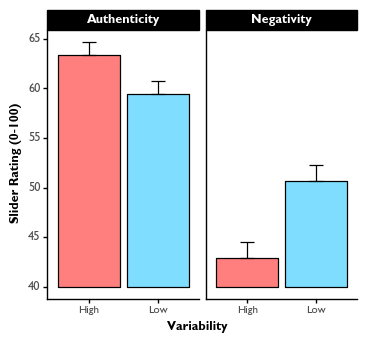

<ggplot: (-9223371925367098736)>

In [68]:
# Use plotnine package to plot using ggplot2 (R) style ...
# Manually recoding y-axis labels using 'slider_mean_40' variable (starting y-axis at zero doesn't look good):
(ggplot(plotData, aes(x='factor(variability)', y='slider_mean_40', fill='factor(variability)')) 
 + geom_errorbar(aes(ymax='slider_mean_40 + slider_sem', ymin='slider_mean_40'), position=position_dodge(width=0.9), width=0.2, color='black')
 + geom_bar(stat='identity', position=position_dodge(width=0.9), alpha=0.5, color='black')
 + scale_fill_manual(values=['red', 'deepskyblue'], guide=False)
 + facet_wrap('~ rating_type', nrow=1)
 + scale_y_continuous(labels=['40', '45', '50', '55', '60', '65'])
 + labs(x='Variability', y='Slider Rating (0-100)')
 + theme_classic()
 + theme(figure_size = (4, 3.5),
         text = element_text(family='Gill Sans MT'),
         axis_text_x = element_text(size = 8),
         axis_title_x = element_text(size = 9, weight = 'bold'),
         axis_text_y = element_text(size = 9),
         axis_title_y = element_text(size = 9, weight = 'bold'),
         axis_line_x = element_line(color = 'black'),
         axis_line_y = element_line(color = 'black'),
         strip_text_x = element_text(weight = 'bold', color = 'white', size = 9), 
         strip_background = element_rect(fill = 'black')))
  